# MNIST Handwritten Digit Generation using GAN

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('Running TF without GPU')
else:
    print(f'Found GPU at {device_name}')

Running TF without GPU


In [2]:
%matplotlib inline

import glob
import imageio
import math
import os
import seaborn as sn
import time

from abc import abstractstaticmethod
from matplotlib import gridspec
from matplotlib import pyplot as plt
from PIL import Image
from tensorflow import keras

sn.set_theme()

In [3]:
NOISE_DIMENSION = 100
TRAIN_SIZE = 60000
TEST_SIZE = 10000
BATCH_SIZE = 128
EPOCHS = 200

EPSILON = 1e-7
N_EXAMPLES = 12
G_LEARNING_RATE = 1e-4
D_LEARNING_RATE = 1e-4

ARCH = 'gan'
path_prefix = ''

IN_COLAB = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path_prefix = '/content/drive/My Drive/gan-vae/gan/'
    IN_COLAB = True
except:
    IN_COLAB = False
    
METRICS_PATH = f'{path_prefix}metrics/{ARCH}/'
OUTPUT_PATH = f'{path_prefix}output/{ARCH}/'

if not IN_COLAB:
    !mkdir -p $METRICS_PATH
    !mkdir -p $OUTPUT_PATH

In [4]:
assert NOISE_DIMENSION > 0
assert TRAIN_SIZE <= 600000
assert TEST_SIZE <= 10000
assert BATCH_SIZE >= 1
assert EPOCHS >= 1
assert N_EXAMPLES >= 1
assert G_LEARNING_RATE > 0
assert D_LEARNING_RATE > 0
assert EPSILON > 0
assert N_EXAMPLES <= TEST_SIZE

## Base Class

In [5]:
class BaseNetwork(tf.Module):
    def __init__(self):
        super().__init__()

    @tf.Module.with_name_scope
    def __call__(self, input_data, training=False) -> tf.Tensor:
        output_data = input_data
        for layer in self.layers:
            output_data = layer(output_data, training=training)
        return output_data

    @abstractstaticmethod
    def loss() -> tf.Tensor:
        raise NotImplementedError

    @abstractstaticmethod
    def optimizer(*args, **kwargs) -> tf.optimizers.Optimizer:
        raise NotImplementedError

## Generator Network
### Layers
<pre>
<b>Input</b>:  input_size=(128, 1)
<b>Dense</b>:  units=128, activation=ReLU
<b>Dense</b>:  units=256, activation=ReLU
<b>Dense</b>:  units=512, activation=ReLU
<b>Dense</b>:  units=784, activation=tanh, target_shape=(28, 28, 1)
</pre>

### Optimizer
<pre>
<b>Adam</b>:  learning_rate=0.0002
</pre>

### Loss
&#8466;<sub>G</sub>(<i><b>z</b></i>) = <sup>-1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> log <i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>))

### Goal
Find argmin<sub>G</sub> {&#8466;<sub>G</sub>(<i><b>z</b></i>)}

In [6]:
class Generator(BaseNetwork):
    def __init__(self, noise_dimension: int, output_shape: tuple) -> None:
        super().__init__()
        # Network layers
        self.layers = [
            keras.layers.InputLayer(input_shape=(noise_dimension,)),
            keras.layers.Flatten(),
            keras.layers.Dense(units=128),
            keras.layers.ReLU(),
            keras.layers.Dense(units=256),
            keras.layers.ReLU(),
            keras.layers.Dense(units=512),
            keras.layers.ReLU(),
            keras.layers.Dense(units=tf.reduce_prod(output_shape)),
            keras.layers.Reshape(target_shape=output_shape),
            keras.layers.Activation(tf.nn.tanh),
        ]

    @staticmethod
    def optimizer(learning_rate: float) -> tf.optimizers.Optimizer:
        return tf.optimizers.Adam(learning_rate=learning_rate)

    @staticmethod
    @tf.function
    def loss(generated_output):
        loss_i = tf.math.log(generated_output+EPSILON)
        loss = -tf.math.reduce_mean(loss_i)
        return loss

## Discriminator Network
### Layers
<pre>
<b>Input</b>:    input_size=(28, 28, 1)
<b>Dense</b>:    units=512, activation=ReLU
<b>Dropout</b>:  rate=0.4
<b>Dense</b>:    units=512, activation=ReLU
<b>Dropout</b>:  rate=0.3
<b>Dense</b>:    units=512, activation=ReLU
<b>Dropout</b>:  rate=0.3
<b>Dense</b>:    units=256, activation=ReLU
<b>Dropout</b>:  rate=0.2
<b>Dense</b>:    units=128, activation=ReLU
<b>Dropout</b>:  rate=0.1
<b>Dense</b>:    units=64, activation=ReLU
<b>Dense</b>:    units=1, activation=sigmoid
</pre>

### Optimizer
<pre>
<b>Adam</b>:         learning_rate=0.0002
</pre>

### Loss
&#8466;<sub>D</sub>(<i><b>x</b>,<b>z</b></i>) = <sup>-1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> \[log <i>D</i>(<i><b>x</b><sup>(i)</sup></i>) + log (1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))\]

### Goal
Find argmin<sub>D</sub> &#8466;<sub>D</sub>(<i><b>x</b></i>,<i><b>z</b></i>)

In [7]:
class Discriminator(BaseNetwork):
    def __init__(self, input_shape: tuple) -> None:
        super().__init__()
        # Network layers
        self.layers = [
            keras.layers.InputLayer(input_shape=input_shape),
            keras.layers.Flatten(),
            keras.layers.Dense(units=512),
            keras.layers.Dropout(rate=0.3),
            keras.layers.ReLU(),
            keras.layers.Dense(units=512),
            keras.layers.Dropout(rate=0.3),
            keras.layers.ReLU(),
            keras.layers.Dense(units=256),
            keras.layers.Dropout(rate=0.2),
            keras.layers.ReLU(),
            keras.layers.Dense(units=128),
            keras.layers.ReLU(),
            keras.layers.Dense(units=1),
            keras.layers.Activation(tf.nn.sigmoid),
        ]

    @staticmethod
    def optimizer(learning_rate: float):
        return tf.optimizers.Adam(learning_rate=learning_rate)

    @staticmethod
    @tf.function
    def loss(trained_ouput, generated_output) -> tf.Tensor:
        loss_i = tf.math.log(trained_ouput+EPSILON) + tf.math.log1p(-generated_output+EPSILON)
        loss = -tf.math.reduce_mean(loss_i)
        return loss

## Preprocessing
* Import MNIST training images
* Normalize to \[-1, 1\]
* Shuffle and batch dataset

In [8]:
(train_images, _), (test_images, _) = keras.datasets.mnist.load_data()

train_images = tf.dtypes.cast((train_images[:TRAIN_SIZE]-127.5) / 127.5, tf.float32)
train_images = tf.expand_dims(input=train_images, axis=-1)
train_ds = tf.data.Dataset.from_tensor_slices(train_images) \
                          .shuffle(TRAIN_SIZE) \
                          .batch(BATCH_SIZE)

test_images = tf.dtypes.cast((train_images[:TEST_SIZE]-127.5) / 127.5, tf.float32)
test_images = tf.expand_dims(input=test_images, axis=-1)

### Initialize Generator and Discriminator

In [9]:
generator = Generator(noise_dimension=NOISE_DIMENSION, output_shape=(train_images.shape[1:]))
generator_optimizer = generator.optimizer(G_LEARNING_RATE)

discriminator = Discriminator(input_shape=(train_images.shape[1:]))
discriminator_optimizer = discriminator.optimizer(D_LEARNING_RATE)

In [10]:
fixed_noise = tf.random.normal([N_EXAMPLES, NOISE_DIMENSION])
metric_names = ['g_loss', 'd_loss', 'real_acc', 'fake_acc']
batch_history = { name: [] for name in metric_names }
epoch_history = { name: [] for name in metric_names[2:] }

In [11]:
def record_sample(generator: Generator, epoch: int, save: bool=True, show=True):
    fixed_predictions = generator(fixed_noise)
    random_predictions = generator(tf.random.normal(fixed_noise.shape))

    titles = ['Fixed Noise Samples', 'Variational Noise Samples']
    data = [fixed_predictions, random_predictions]

    f = plt.figure(figsize=(8, 4))
    f.suptitle('GAN Output')
    outer = gridspec.GridSpec(1, 2)

    for i in range(2):
        inner = gridspec.GridSpecFromSubplotSpec(int(math.sqrt(N_EXAMPLES)), int(math.sqrt(N_EXAMPLES)), subplot_spec=outer[i])
        predictions = data[i]
        for j in range(predictions.shape[0]):
            ax = plt.Subplot(f, inner[j])
            ax.imshow(predictions[j]*127.5 + 127.5, cmap=plt.cm.gray)
            ax.axis('off')
            if j == int(math.sqrt(N_EXAMPLES)) // 2:
                ax.set_title(titles[i])
            f.add_subplot(ax)

    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'epoch_{:04d}.png'.format(epoch)))
    if show:
        plt.show()
    plt.close()

### Accuracy

In [12]:
def real_accuracy(real_output) -> tf.Tensor:
    # Trained images fed into D have output 1 
    real_acc = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(tf.math.round(real_output), 1.), tf.float32))
    return real_acc

def accuracy(real_output, fake_output) -> tuple:
    # Images from G's noisy distribution should have output 0 from D
    correct_fake_output = tf.zeros_like(fake_output)
    fake_acc = tf.math.reduce_mean(tf.dtypes.cast(tf.math.equal(tf.math.round(fake_output), 0.), tf.float32))

    return real_accuracy(real_output), fake_acc

## GAN Algorithm
<pre>
<b>for</b> number of training iterations <b>do</b>
  <b>for</b> k steps <b>do</b>
     • Sample minibatch of <i>m</i> noise samples {<i><b>z</b><sup>(1)</sup>, ..., <b>z</b><sup>(m)</sup></i>} from noise prior <i>p<sub>g</sub>(<b>z</b>)</i>.
     • Sample minibatch of <i>m</i> examples {<i><b>x</b><sup>(1)</sup>, ..., <b>x</b><sup>(m)</sup></i>} from data generating distribution <i>p<sub>data</sub>(<b>x</b>)</i>.
     • Update the discriminator by <u>ascending</u> its stochastic gradient:
       <center>&Del;<sub>&theta;<sub>d</sub></sub> <sup>1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> [log <i>D</i>(<i><b>x</b><sup>(i)</sup></i>) + log(1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))]</center>
  <b>end for</b>
  • Sample minibatch of <i>m</i> noise samples {<i><b>z</b><sup>(1)</sup>, ..., <b>z</b><sup>(m)</sup></i>} from noise prior <i>p<sub>g</sub>(<b>z</b>)</i>.
  • Update the generator by <u>descending</u> its stochastic gradient:
  <center>&Del;<sub>&theta;<sub>d</sub></sub> <sup>1</sup>&frasl;<sub>m</sub> &lowast; &sum;<sub><i>i</i></sub> log(1-<i>D</i>(G(<i><b>z</b><sup>(i)</sup></i>)))</center>
<b>end for</b>
</pre>

Source: https://arxiv.org/pdf/1406.2661.pdf

In [13]:
record_sample(generator, 0, show=False)
steps_per_epoch = train_images.shape[0] // BATCH_SIZE

for epoch in range(1, EPOCHS+1):
    print(f'\nepoch {epoch}/{EPOCHS}')
    progress_bar = keras.utils.Progbar(steps_per_epoch, stateful_metrics=metric_names)

    for i, image_batch in enumerate(train_ds):

        num_samples = image_batch.shape[0]
        noise = tf.random.normal([num_samples, NOISE_DIMENSION])

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            # Train G on noise
            generated_images = generator(noise, training=True)
            # Train D on training images
            trained_output = discriminator(image_batch, training=True)
            # Train D on generated images
            generated_output = discriminator(generated_images, training=True)

            # Calculate loss
            g_loss = generator.loss(generated_output)
            d_loss = discriminator.loss(trained_output, generated_output)

        real_acc, fake_acc = accuracy(trained_output, generated_output)

        batch_metrics = {
            'g_loss': g_loss,
            'd_loss': d_loss,
            'real_acc': real_acc,
            'fake_acc': fake_acc,
        }

        # Record loss history
        for metric in batch_history:
            batch_history[metric].append(batch_metrics[metric])
    
        batch_metric_values = batch_metrics.items()
        progress_bar.update(i, values=batch_metric_values)        

        # https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient
        grad_g = g_tape.gradient(g_loss, generator.trainable_variables)
        grad_d = d_tape.gradient(d_loss, discriminator.trainable_variables)

        # https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients
        generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))

    for metric in epoch_history:
        epoch_history[metric].append(batch_history[metric][-1])

    progress_bar.update(steps_per_epoch, values=batch_metric_values, finalize=True)

    record_sample(generator, epoch, show=False)


epoch 1/200
468/468 [==============================] - 49s 106ms/step - g_loss: 5.5878 - d_loss: 0.2965 - real_acc: 0.9062 - fake_acc: 0.9792

epoch 2/200
468/468 [==============================] - 50s 107ms/step - g_loss: 11.2064 - d_loss: 0.0330 - real_acc: 0.9896 - fake_acc: 1.0000

epoch 3/200
468/468 [==============================] - 54s 115ms/step - g_loss: 4.2426 - d_loss: 0.1508 - real_acc: 0.9479 - fake_acc: 1.0000

epoch 4/200
468/468 [==============================] - 70s 151ms/step - g_loss: 8.8884 - d_loss: 0.0467 - real_acc: 0.9896 - fake_acc: 1.0000

epoch 5/200
468/468 [==============================] - 93s 199ms/step - g_loss: 4.5293 - d_loss: 0.1438 - real_acc: 0.9479 - fake_acc: 1.0000

epoch 6/200
468/468 [==============================] - 74s 159ms/step - g_loss: 4.6851 - d_loss: 0.0409 - real_acc: 0.9896 - fake_acc: 1.0000

epoch 7/200
468/468 [==============================] - 62s 132ms/step - g_loss: 5.6782 - d_loss: 0.0664 - real_acc: 1.0000 - fake_acc: 0.989

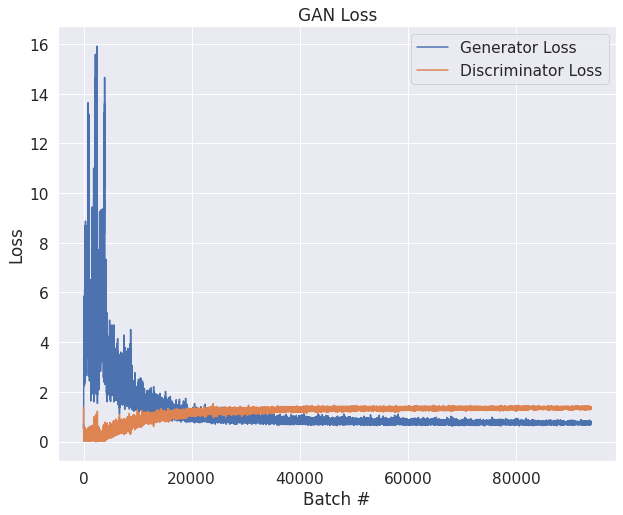

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(tf.math.reduce_mean(tf.reshape(batch_history['g_loss'], shape=(-1, math.ceil(TRAIN_SIZE / BATCH_SIZE))), axis=1), label='Generator Loss')
plt.plot(tf.math.reduce_mean(tf.reshape(batch_history['d_loss'], shape=(-1, math.ceil(TRAIN_SIZE / BATCH_SIZE))), axis=1), label='Discriminator Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.title('GAN Loss')
plt.legend()
plt.savefig(os.path.join(METRICS_PATH, 'loss.png'))
plt.show()
plt.close()

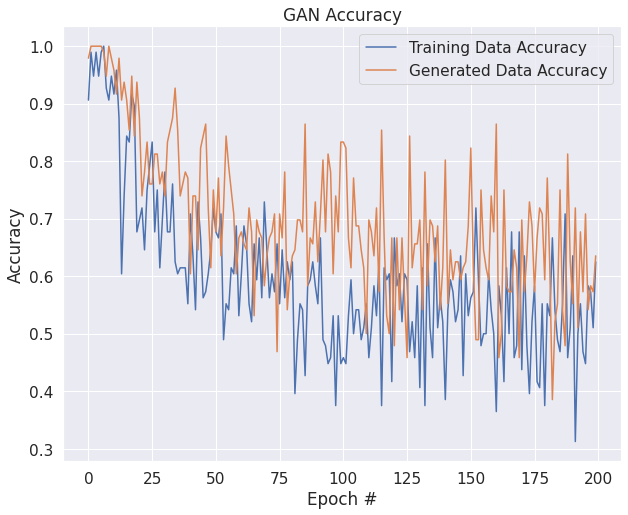

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(tf.math.reduce_mean(tf.reshape(batch_history['acc'], shape=(-1, math.ceil(TRAIN_SIZE / BATCH_SIZE))), axis=1), label='Total Accuracy')
plt.plot(tf.math.reduce_mean(tf.reshape(batch_history['real_acc'], shape=(-1, math.ceil(TRAIN_SIZE / BATCH_SIZE))), axis=1), label='Training Data Accuracy')
plt.plot(tf.math.reduce_mean(tf.reshape(batch_history['fake_acc'], shape=(-1, math.ceil(TRAIN_SIZE / BATCH_SIZE))), axis=1), label='Generated Data Accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.title('GAN Accuracy')
plt.legend()
plt.savefig(os.path.join(METRICS_PATH, 'accuracy.png'))
plt.show()
plt.close()

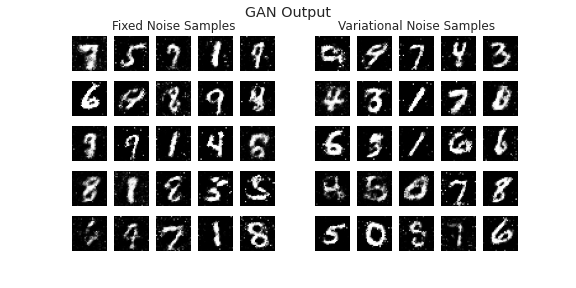

In [17]:
with imageio.get_writer(os.path.join(METRICS_PATH, f'{ARCH}.gif'), mode='I') as writer:
    filenames = glob.glob(os.path.join(OUTPUT_PATH, 'epoch*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

last_epoch_img = 'epoch_{:04d}'.format(EPOCHS)
last_epoch_img_output = os.path.join(OUTPUT_PATH, last_epoch_img)
last_epoch_img_metrics = os.path.join(METRICS_PATH, last_epoch_img)
Image.open(last_epoch_img_output).save(last_epoch_img_metrics)